__Задание__

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [97]:
from scipy.optimize import minimize
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
passengers = airlines_passengers['Count']
#сразу делаю ряд стационарным
passengers_stat = np.diff(np.diff(boxcox(passengers, 0)), 12)

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
test_stationarity(passengers_stat)

Results of Dickey-Fuller Test:
Test Statistic                -1.609085e+01
p-value                        5.255378e-29
#Lags Used                     1.300000e+01
Number of Observations Used    1.170000e+02
Critical Value (1%)           -3.487517e+00
Critical Value (5%)           -2.886578e+00
Critical Value (10%)          -2.580124e+00
dtype: float64


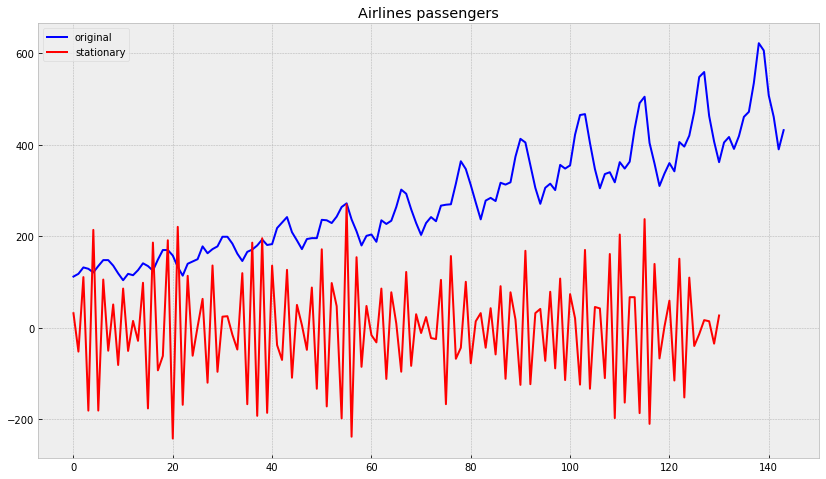

In [5]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(passengers, color='blue', label='original')
    plt.plot(passengers_stat, color='red', label='stationary')
    plt.legend()
    plt.title('Airlines passengers')

## Приближение оригинального временого ряда

Во временном ряде есть тренд и сезонность, поэтому для приблежения лучше всего подходит метод Хольта-Винтерса.

In [91]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [92]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0:
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

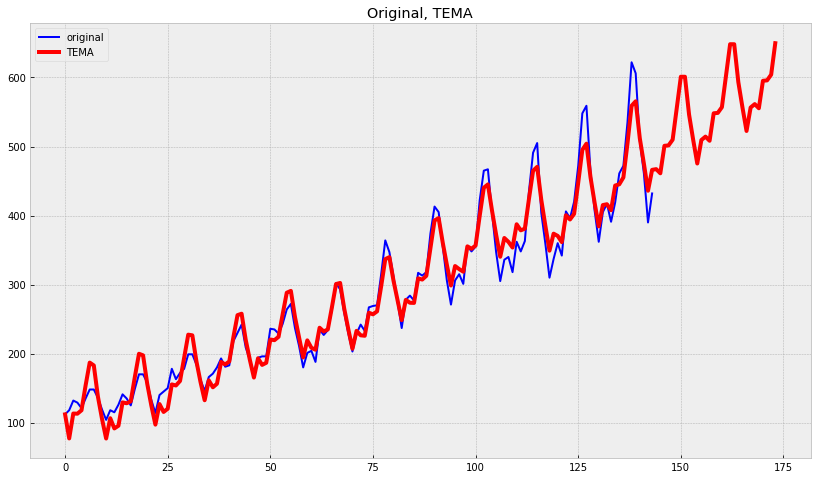

In [95]:
with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(passengers, color='blue',label='original')
        plt.plot(triple_exponential_smoothing(passengers, 12, 0.1, 0.1, 0.1, 30), color='red', linewidth='4', label='TEMA')
        plt.title('Original, TEMA')
        plt.legend()

In [166]:
def mse_cross_val(X, series):
    series = pd.Series(series)
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(series):
        train_split_ts = series.iloc[train_split]
        test_split_ts = series.iloc[test_split]
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    return np.mean(np.array(errors))

In [119]:
# Для подбора коэффициентов использую три метода из minimize, потому что только у них есть возможность выставить ограничения.
opt = minimize(mse_cross_val, x0=[0,0,0], args=passengers, method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))
print(opt)

 final_simplex: (array([[0.25259005, 0.        , 1.        ],
       [0.25266165, 0.        , 1.        ],
       [0.2526855 , 0.        , 1.        ],
       [0.25255054, 0.        , 1.        ]]), array([4162.9306536 , 4162.93065688, 4162.93068025, 4162.93069475]))
           fun: 4162.9306535966125
       message: 'Optimization terminated successfully.'
          nfev: 175
           nit: 98
        status: 0
       success: True
             x: array([0.25259005, 0.        , 1.        ])


In [121]:
opt = minimize(mse_cross_val, x0=[0,0,0], args=passengers, method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
print(opt)

      fun: 3613.202546657833
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.36646288e-04,  1.17779564e-02, -8.81550473e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 80
      nit: 17
     njev: 20
   status: 0
  success: True
        x: array([0.97325366, 0.02865439, 1.        ])


In [123]:
# Метод Пауэлла выдал лучший результат из всех трех
opt = minimize(mse_cross_val, x0=[0,0,0], args=passengers, method="Powell", bounds = ((0, 1), (0, 1), (0, 1)))
print(opt)

   direc: array([[ 8.51036818e-02,  3.88779050e-02, -9.12180409e-09],
       [-8.24688735e-06,  1.28164630e-05,  6.41596474e-05],
       [-2.92729714e-11,  5.33684386e-09,  1.29664133e-10]])
     fun: 413.99294882606426
 message: 'Optimization terminated successfully.'
    nfev: 669
     nit: 8
  status: 0
 success: True
       x: array([0.29425357, 0.17250906, 1.        ])


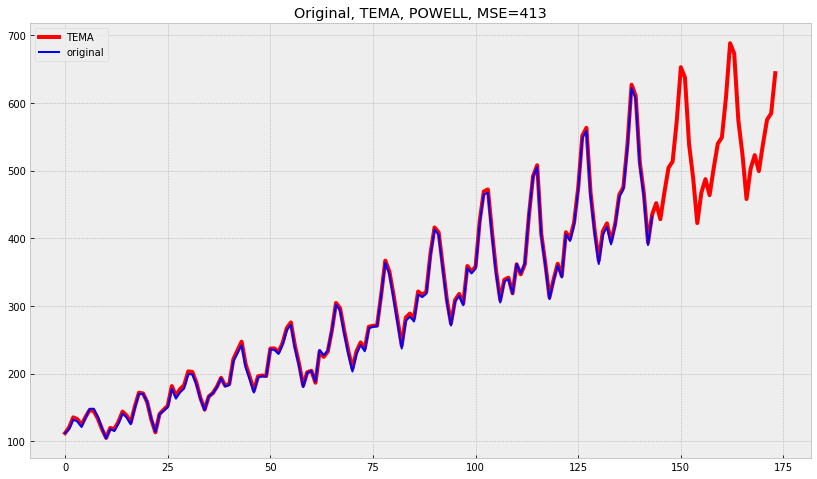

In [183]:
with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(triple_exponential_smoothing(passengers, 12, 0.29425357, 0.17250906, 1, 30), color='red', linewidth='4', label='TEMA')
        plt.plot(passengers, color='blue',label='original')
        plt.title('Original, TEMA, POWELL, MSE=413')
        plt.legend()

Выглядит как идеальное предсказание


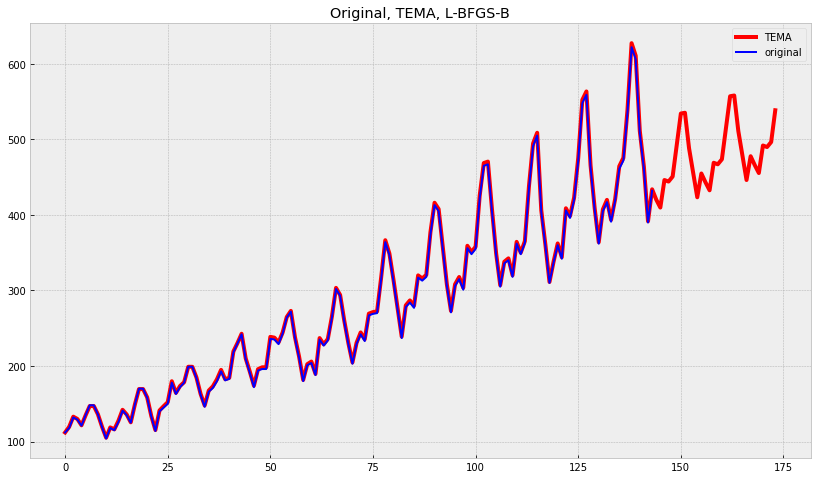

In [127]:
with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(triple_exponential_smoothing(passengers, 12, 0.97325366, 0.02865439, 1, 30), color='red', linewidth='4', label='TEMA')
        plt.plot(passengers, color='blue',label='original')
        plt.title('Original, TEMA, L-BFGS-B')
        plt.legend()

Виден тренд, но колебания гораздо меньше, чем должны быть

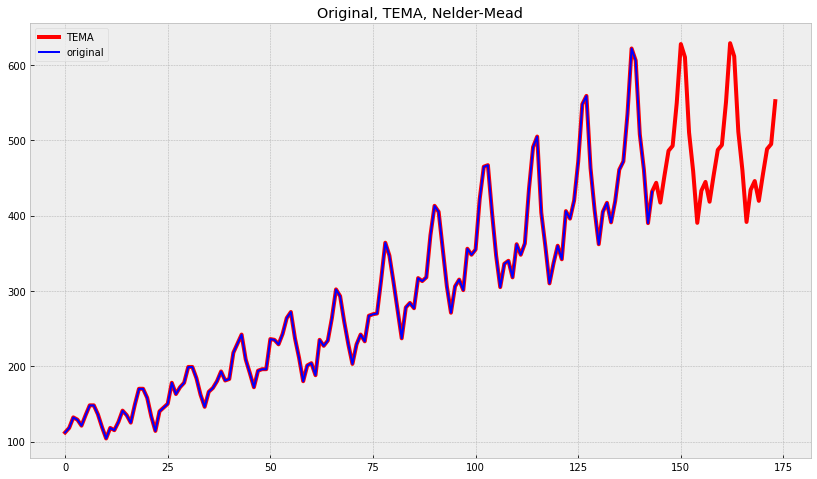

In [184]:
with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(triple_exponential_smoothing(passengers, 12, 0.25259005, 0, 1, 30), color='red', linewidth='4', label='TEMA')
        plt.plot(passengers, color='blue',label='original')
        plt.title('Original, TEMA, Nelder-Mead')
        plt.legend()

Тренд не учитывается (он взят с нулевым коэффициентом)

## Приближение стационарного временного ряда
Поскольку здесь не должно остаться тренда и сезонности, попробую приблизить ряд с помощью EMA и DEMA.

### EMA

In [129]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n - 1] + (1 - alpha) * result[n - 1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return pd.Series(result)

In [142]:
def mse_cross_val_ema(alpha, series):
    series = pd.Series(series)
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(series):
        train_split_ts = series.iloc[train_split]
        test_split_ts = series.iloc[test_split]
        result = exponential_moving_average(train_split_ts, alpha, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    return np.mean(np.array(errors))

In [143]:
optema = minimize(mse_cross_val_ema, x0=0, args=passengers_stat, method="Nelder-Mead")
print(optema)

 final_simplex: (array([[0.11175  ],
       [0.1118125]]), array([13325.83108879, 13325.83109261]))
           fun: 13325.831088793886
       message: 'Optimization terminated successfully.'
          nfev: 38
           nit: 19
        status: 0
       success: True
             x: array([0.11175])


In [146]:
optema = minimize(mse_cross_val_ema, x0=0, args=passengers_stat, method="POWELL")
print(optema)

   direc: array([[0.00045962]])
     fun: 13325.83108873497
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 2
  status: 0
 success: True
       x: array([0.11175686])


In [147]:
optema = minimize(mse_cross_val_ema, x0=0, args=passengers_stat, method="L-BFGS-B")
print(optema)

      fun: 13325.831088738232
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00418368])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 9
     njev: 18
   status: 0
  success: True
        x: array([0.11175847])


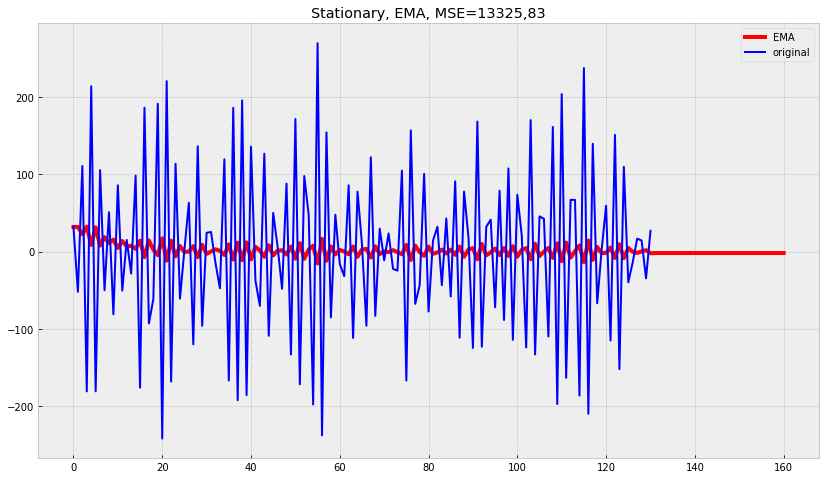

In [180]:
#
with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(exponential_moving_average(passengers_stat, 0.11175, 30), color='red', linewidth='4', label='EMA')
        plt.plot(passengers_stat, color='blue',label='original')
        plt.title('Stationary, EMA, MSE=13325,83')
        plt.legend()

Все три метода выдали один и тот же коэффициент. Ошибка очень большая, по графику видно, что предсказание неточное.

### DEMA

In [154]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return pd.Series(result)

In [158]:
def mse_cross_val_dema(X, series):
    alpha, beta = X
    series = pd.Series(series)
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(series):
        train_split_ts = series.iloc[train_split]
        test_split_ts = series.iloc[test_split]
        result = double_ema_with_preds(train_split_ts, alpha, beta, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    return np.mean(np.array(errors))

In [160]:
optdema = minimize(mse_cross_val_dema, x0=[0, 0], args=passengers_stat, method="POWELL", bounds=((0, 1), (0, 1)))
print(optdema)

   direc: array([[-0.01372909,  0.01035255],
       [-0.00213911,  0.00390967]])
     fun: 14391.071405292367
 message: 'Optimization terminated successfully.'
    nfev: 233
     nit: 7
  status: 0
 success: True
       x: array([0.10980564, 0.24987483])


In [162]:
optdema = minimize(mse_cross_val_dema, x0=[0, 0], args=passengers_stat, method="l-BFGS-B", bounds=((0, 1), (0, 1)))
print(optdema)

      fun: 13574.668174615303
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.08403731, 0.5158654 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 135
      nit: 21
     njev: 45
   status: 0
  success: True
        x: array([0.13756053, 0.07273011])


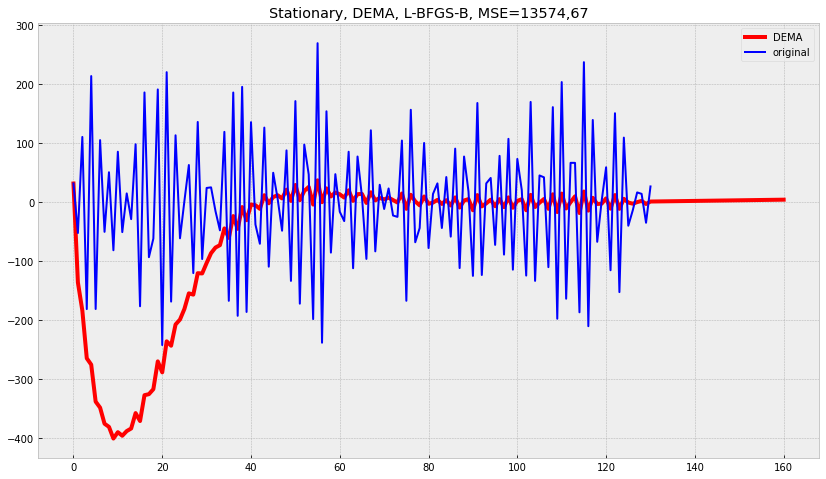

In [181]:
with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(double_ema_with_preds(passengers_stat, 0.13756053, 0.07273011, 30), color='red', linewidth='4', label='DEMA')
        plt.plot(passengers_stat, color='blue',label='original')
        plt.title('Stationary, DEMA, L-BFGS-B, MSE=13574,67')
        plt.legend()

Лучшие коэффициенты нашел L-BFGS-B. Ошибка получилась даже больше, чем у EMA, то есть этот метод тоже не подходит.

### TEMA
Остается только попробовать третий метод

In [167]:
opttema = minimize(mse_cross_val, x0=[0, 0, 0], args=passengers_stat, method="Nelder-Mead", bounds=((0, 1), (0, 1), (0, 1)))
print(opttema)

 final_simplex: (array([[0.18623315, 0.        , 0.22863059],
       [0.18628046, 0.        , 0.22859386],
       [0.18628546, 0.        , 0.22865687],
       [0.18628457, 0.        , 0.22869463]]), array([9082.15961068, 9082.15962775, 9082.15963682, 9082.15966389]))
           fun: 9082.159610681812
       message: 'Optimization terminated successfully.'
          nfev: 131
           nit: 71
        status: 0
       success: True
             x: array([0.18623315, 0.        , 0.22863059])


In [168]:
opttema = minimize(mse_cross_val, x0=[0, 0, 0], args=passengers_stat, method="POWELL", bounds=((0, 1), (0, 1), (0, 1)))
print(opttema)

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-2.28220586e-02,  2.05401999e-02,  2.12001503e-02],
       [-1.81839423e-04,  1.47817134e-02, -1.20885788e-02]])
     fun: 6107.999848067811
 message: 'Optimization terminated successfully.'
    nfev: 226
     nit: 6
  status: 0
 success: True
       x: array([0.04810505, 0.11610318, 0.22315353])


In [170]:
opttema = minimize(mse_cross_val, x0=[0, 0, 0], args=passengers_stat, method="L-BFGS-B", bounds=((0, 1), (0, 1), (0, 1)))
print(opttema)

      fun: 6107.972375702139
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00491127,  0.02710294, -0.01246008])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 96
      nit: 20
     njev: 24
   status: 0
  success: True
        x: array([0.04824488, 0.11671377, 0.22471678])


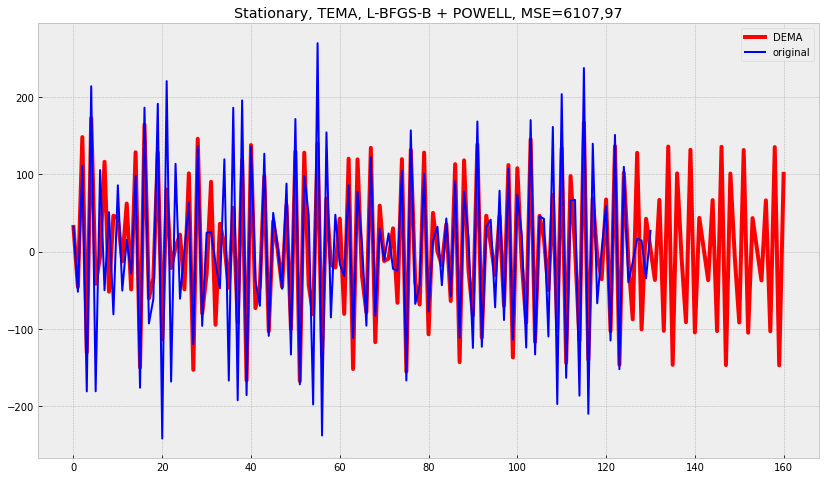

In [186]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(triple_exponential_smoothing(passengers_stat, 12, 0.04824488, 0.11671377, 0.22471678, 30),
                 color='red', linewidth='4', label='DEMA')
    plt.plot(passengers_stat, color='blue',label='original')
    plt.title('Stationary, TEMA, L-BFGS-B + POWELL, MSE=6107,97')
    plt.legend()

Это лучший результат, которого удалось добиться для стационарного временного ряда. Возможно, в нем все-таки присутствует сезонность, и необходимо строить модель с ее учетом.